# Satellite Acquisition 
## (via the parallel frequency space search algorithm)
### (It still doesn't work)

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

**Note: we should only perform this acquisition method on ~20ms sections of data, see book for details**

## Preamble

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#import peakutils
import struct
import math
import scipy.stats as sp

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData


## Import data File

- Information on file "JGPS@-32.041913222" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [9]:
data = IQData()
data.importFile('../resources/JGPS@-32.041913222', 4.092e6, 1e-3)

Opening a file.
File handle is: 52.
Total Samples to read: 4092
Total Bytes read: 2046.
Which equals 4092 IQ pairs.
Sample Length: 0.001000 seconds.
File is now closed.


## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

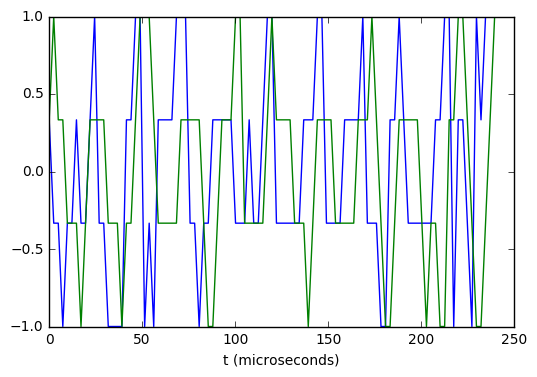

In [11]:
scale = 1/4.092e6
x = np.linspace(0,99,100)
x = x * scale * 10e6

plt.plot(x, np.real(data.CData[0:100]))
plt.plot(x, np.imag(data.CData[0:100]))

#plt.plot(np.real(CData))
#plt.plot(np.imag(CData))

plt.xlabel("t (microseconds)")
plt.savefig("./plot/meep")
plt.show()

In [12]:
data = IQData()
data.importFile('../resources/JGPS@-32.041913222')

Opening a file.
File handle is: 53.
Total Samples to read: 4092
Total Bytes read: 2046.
Which equals 4092 IQ pairs.
Sample Length: 0.001000 seconds.
File is now closed.


# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.
- The numpy.repeat() function does this exactly


In [5]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 4000

def getSat(select):
    # Create list of C/A code Taps, for simpler sat selection",
    #sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
    sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[select - 1]) # Index starts at zero

    # Generate CA Code
    CACode = CodeGen.getCode(1023)

    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)
    print("Satellite chosen: %d, with tap: %s" %(select,str(sat[select - 1])))

    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
    print(len(CACodeSampled))
    return CACodeSampled

# Multiply Signal and Code

In [6]:
nfft = TotalSamples

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs#/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)

#fstep = fs/N
fax = np.linspace(0, fs * 2, nfft)

from collections import deque
cadeque = deque()

#for i in CACodeSampled:
#    cadeque.append(i)
    
def mixnplot(CACodeSampled, mixedData, nfft, f, lab, plots = False):
    
    mixedData = CData * CACodeSampled
    fftData = np.fft.fft(mixedData, nfft)

    psd = np.abs(fftData) ** 2

    psddb = (10 * np.log10(psd))
    
    #Set plots to True if you want to look over 1023 plots manually
    if plots:
        psddb_norm = psddb - np.max(psddb)
        
        plt.title("Iter: " + str(lab))
        plt.plot(fax/1000, psddb_norm)
        savedir = './plot2/' + str(lab)
        plt.savefig(savedir)
        plt.clf()
    
    #Return the ratio of the highest peak
    return psddb.max()/psddb.mean()

# Get 32 CA codes, mix them, and plot the peak ratios

Satellite chosen: 0, with tap: (3, 9)
4092


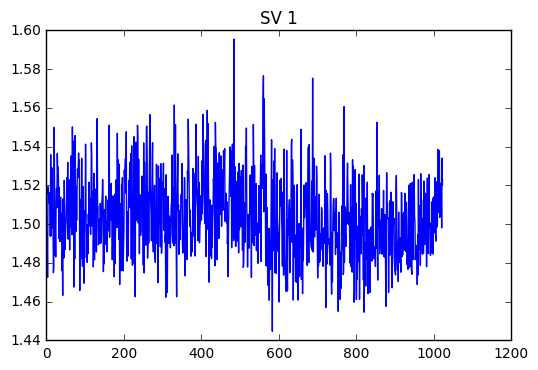

Satellite chosen: 1, with tap: (1, 5)
4092


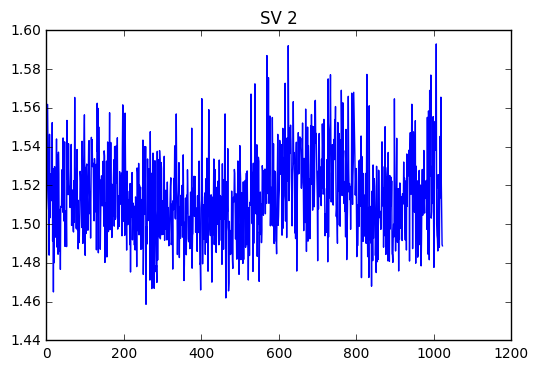

Satellite chosen: 2, with tap: (2, 6)
4092


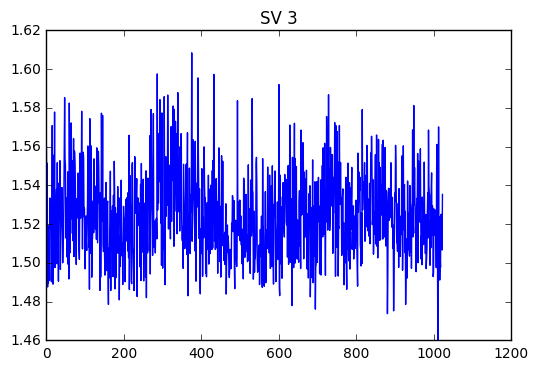

Satellite chosen: 3, with tap: (3, 7)
4092


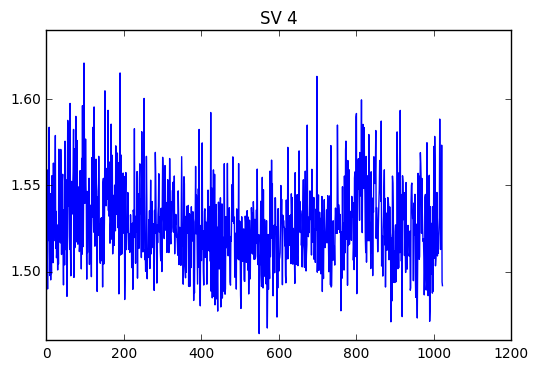

Satellite chosen: 4, with tap: (4, 8)
4092


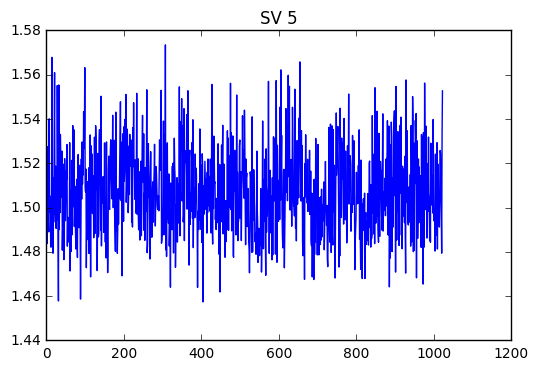

Satellite chosen: 5, with tap: (0, 8)
4092


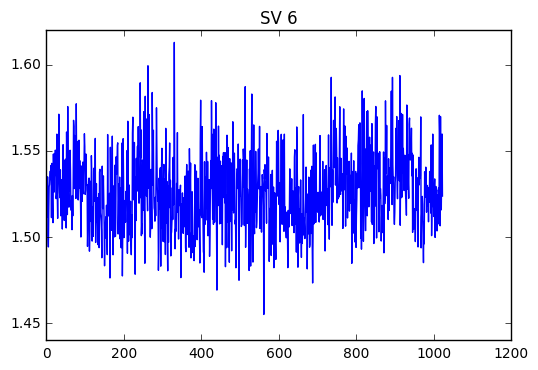

Satellite chosen: 6, with tap: (1, 5)
4092


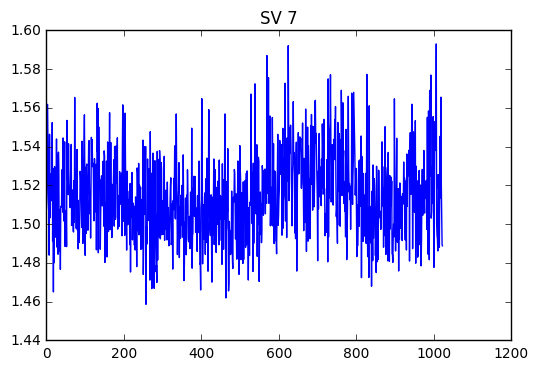

Satellite chosen: 7, with tap: (0, 7)
4092


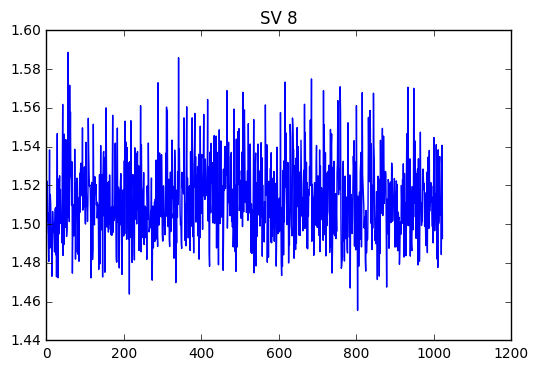

Satellite chosen: 8, with tap: (1, 8)
4092


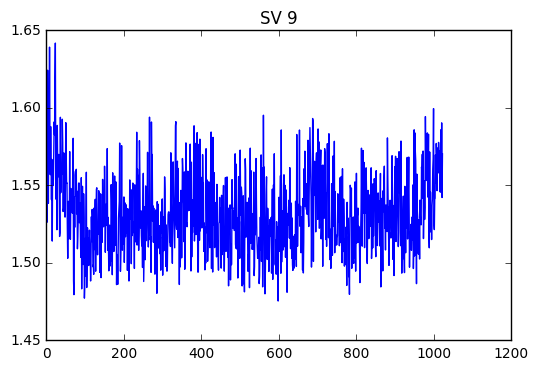

Satellite chosen: 9, with tap: (2, 9)
4092


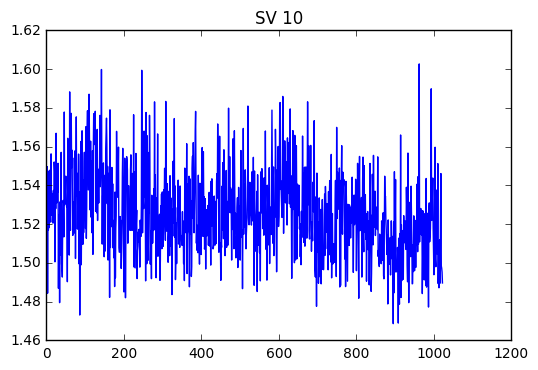

Satellite chosen: 10, with tap: (1, 2)
4092


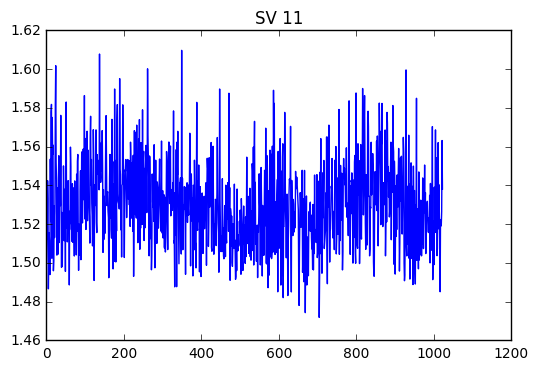

Satellite chosen: 11, with tap: (2, 3)
4092


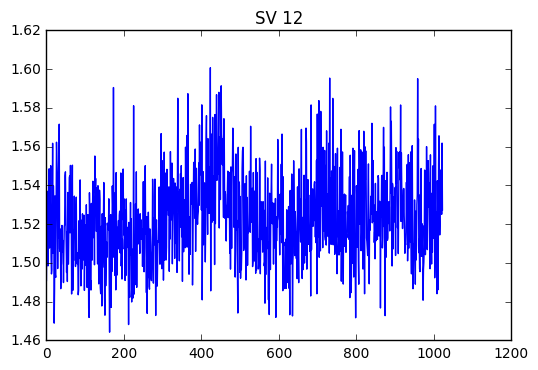

Satellite chosen: 12, with tap: (4, 5)
4092


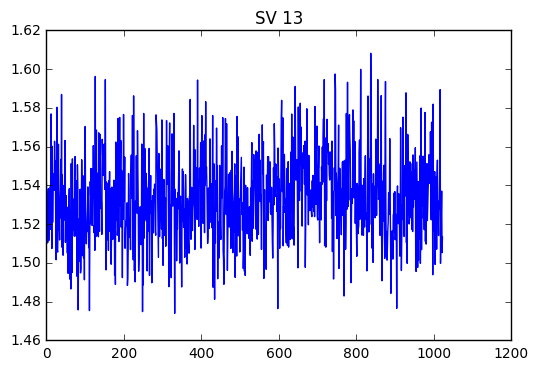

Satellite chosen: 13, with tap: (5, 6)
4092


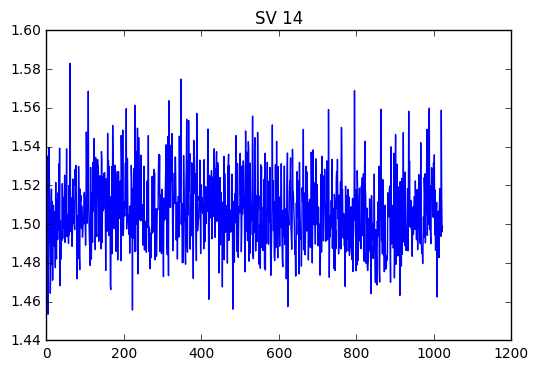

Satellite chosen: 14, with tap: (6, 7)
4092


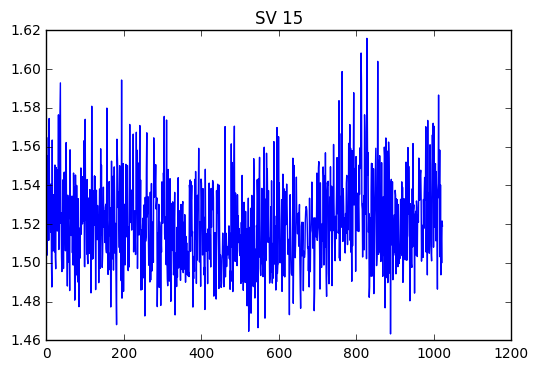

Satellite chosen: 15, with tap: (7, 8)
4092


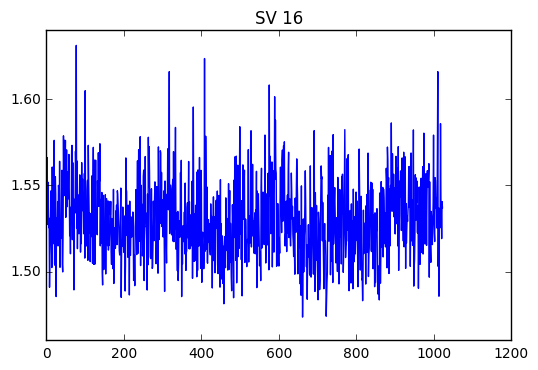

Satellite chosen: 16, with tap: (8, 9)
4092


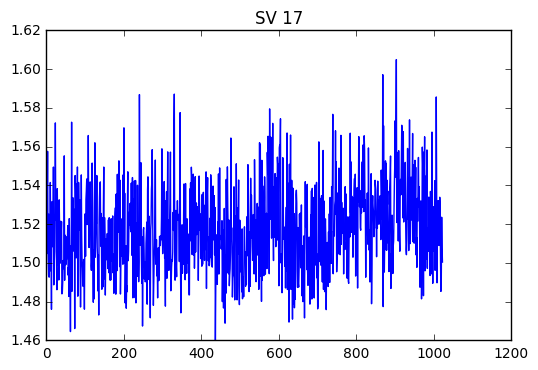

Satellite chosen: 17, with tap: (0, 3)
4092


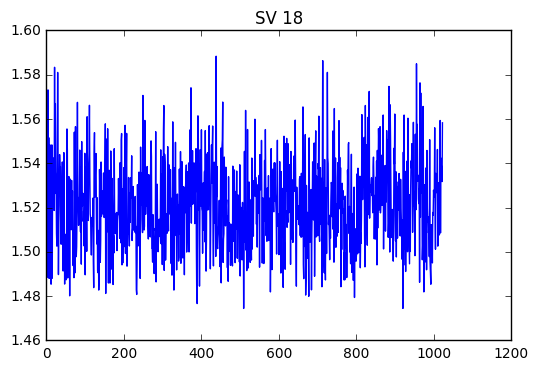

Satellite chosen: 18, with tap: (1, 4)
4092


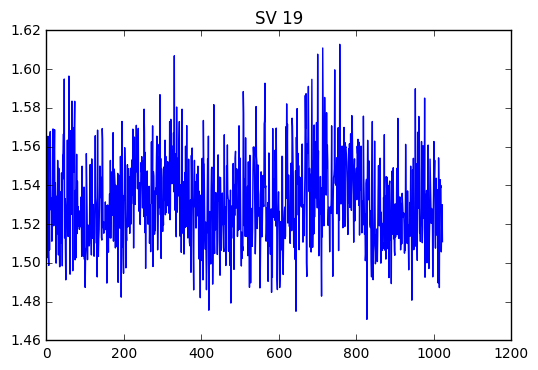

Satellite chosen: 19, with tap: (2, 5)
4092


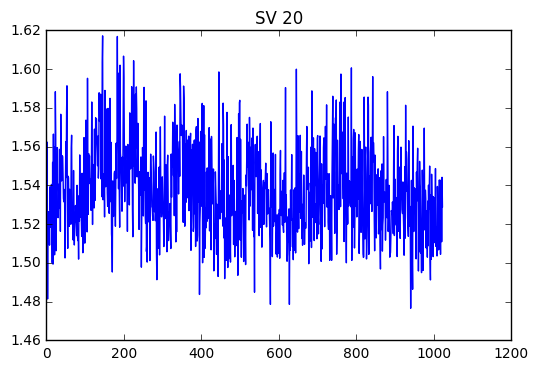

Satellite chosen: 20, with tap: (3, 6)
4092


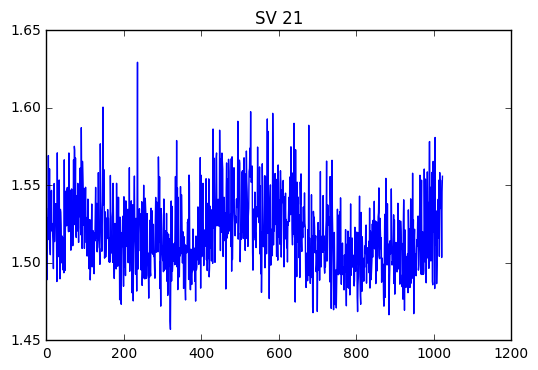

Satellite chosen: 21, with tap: (4, 7)
4092


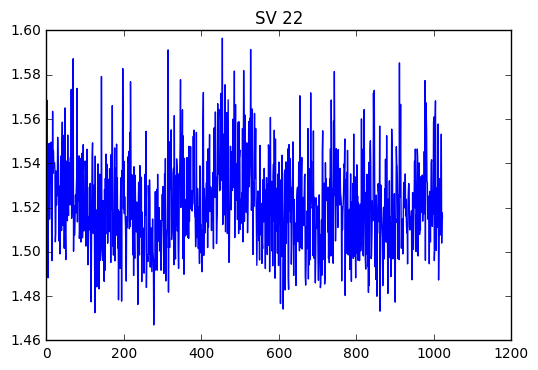

Satellite chosen: 22, with tap: (5, 8)
4092


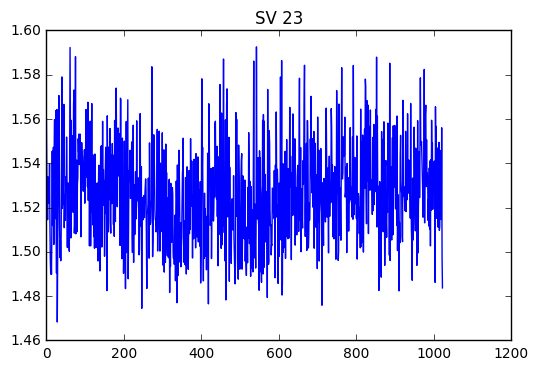

Satellite chosen: 23, with tap: (0, 2)
4092


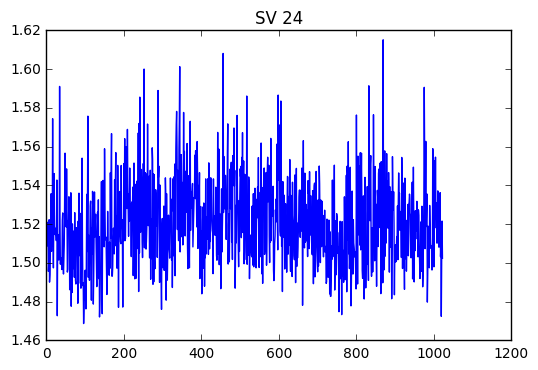

Satellite chosen: 24, with tap: (3, 5)
4092


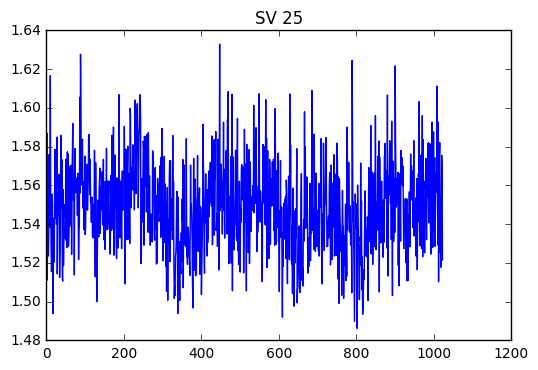

Satellite chosen: 25, with tap: (4, 6)
4092


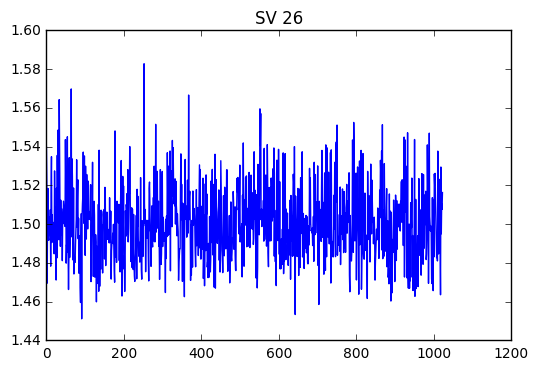

Satellite chosen: 26, with tap: (5, 7)
4092


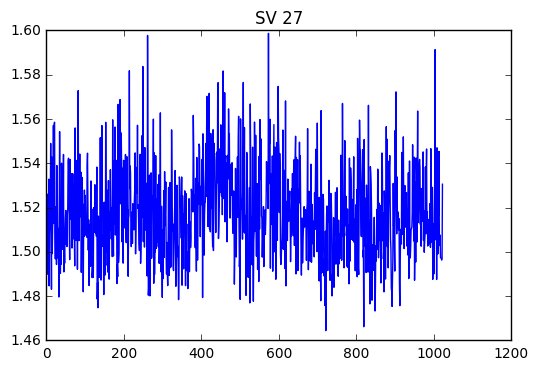

Satellite chosen: 27, with tap: (6, 8)
4092


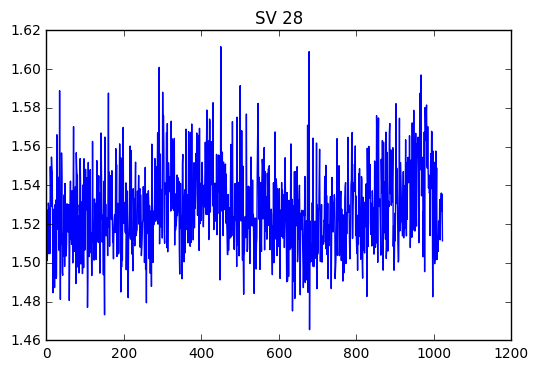

Satellite chosen: 28, with tap: (7, 9)
4092


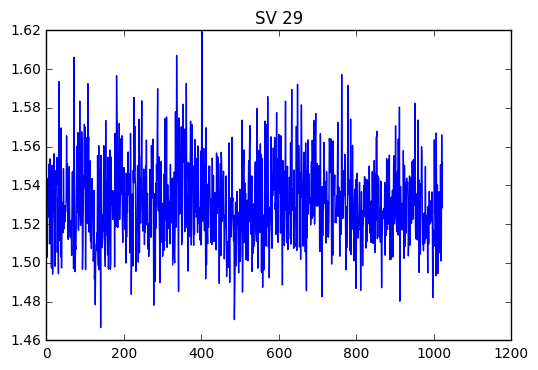

Satellite chosen: 29, with tap: (0, 5)
4092


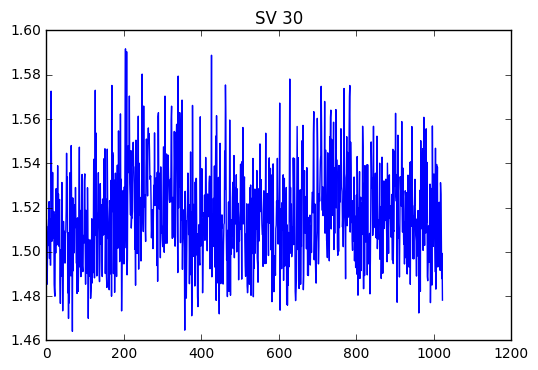

Satellite chosen: 30, with tap: (1, 6)
4092


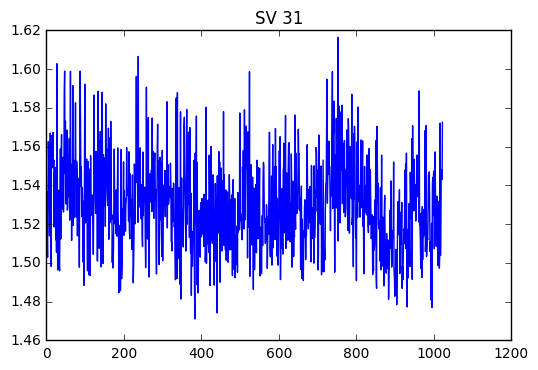

Satellite chosen: 31, with tap: (2, 7)
4092


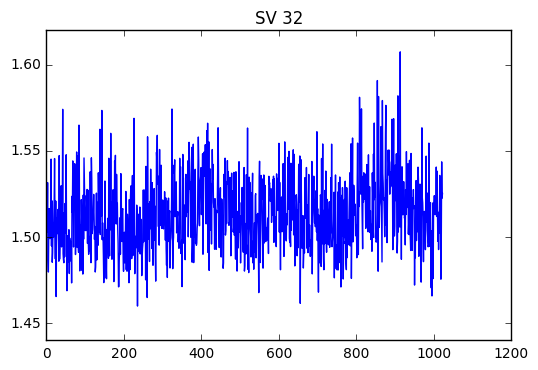

In [9]:
for s in range(32):
    code = getSat(s)
    
    codeq = deque()

    for i in code:
        codeq.append(i)
    
    ratios = []
    for i in range(1023):
        ratio = mixnplot(codeq, CData, nfft, f, str(i))
        ratios.append(ratio)
        codeq.rotate(-4)
        #i += 1
        
        #print(ratio)
        #if i % 10 == 0:
        #   print(str(i*100/1023) + '% complete')
    
    plt.title("SV " + str(s + 1))
    plt.plot(ratios)
    plt.show()
        
    

In [ ]:
plt.plot(ratios)
plt.show()